In [3]:
import sys
sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.discrete.discrete_model import Logit

# Import et préparation des données

In [4]:
train = pd.read_csv("../data/application_train_vf.csv")
test = pd.read_csv("../data/application_test_vf.csv")

In [ ]:
dataprep = DataPreparation(train, test, 0.3)
train_prepared, test_prepared = dataprep.get_prepared_data()

In [5]:
#train_prepared.to_csv("../data/train_prepared.csv")
#test_prepared.to_csv("../data/test_prepared.csv")
train_prepared = pd.read_csv("../data/train_prepared.csv", index_col=[0])
test_prepared = pd.read_csv("../data/test_prepared.csv", index_col=[0])

In [6]:
df_train = train_prepared.copy()

In [7]:
df_validation = df_train.iloc[280000:,:]
df_train = df_train.iloc[:280000,:]

# Modélisation

In [22]:
features = list(train_prepared.iloc[:,2:].columns)

In [23]:
reference_categories = {var : train_prepared[var].mode()[0] for var in features}

In [24]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [25]:
model = Logit.from_formula(formula=formula, data=train_prepared)
logit_model = model.fit_regularized(maxiter = 500, method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2464855970725259
            Iterations: 322
            Function evaluations: 323
            Gradient evaluations: 322


# Prédiction

In [26]:
pred = logit_model.predict(df_validation)

In [27]:
pred = pred.apply(lambda x : 0 if x < 0.5 else 1)

In [28]:
confusion_matrix(pred, df_validation["TARGET"])

array([[23775,  2309],
       [   13,    10]])

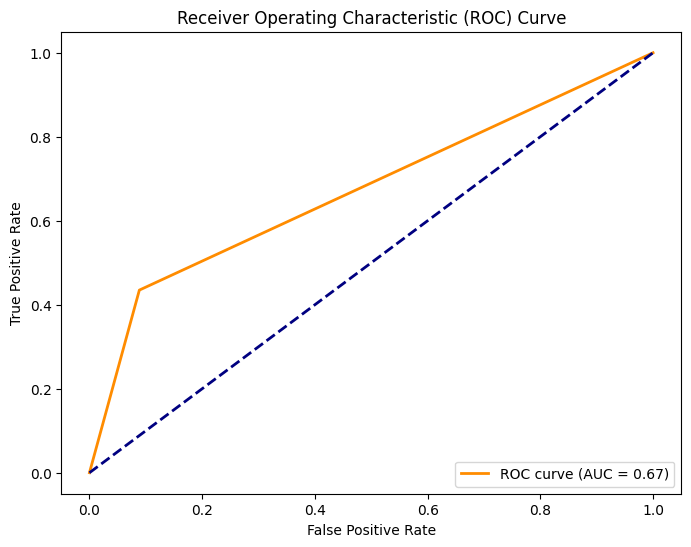

In [29]:
fpr, tpr, thresholds = roc_curve(pred, df_validation["TARGET"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

0.3462609095697513

# Grille de score

In [31]:
GS = GridScore(df_train, logit_model)
grid_score = GS.compute_grid_score()

In [32]:
grid_score

,Variable,Modality,Coefficient,P-Value,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,Intercept,-,-2.490171,0.0000,0.000000,0.0,0.00,0.00
1,DAYS_BIRTH_disc_int,[-19553;-13376]_ref,0.000000,0.0000,1.800180,2.0,3.07,42.32
2,DAYS_BIRTH_disc_int,[-13375;-7489],0.020000,0.2329,0.000000,2.0,3.20,31.71
3,DAYS_BIRTH_disc_int,[-25229;-19554],-0.240000,0.0000,23.402340,2.0,1.30,25.97
4,EXT_SOURCE_2_disc_int,[0.49;0.85]_ref,0.000000,0.0000,108.010801,10.0,3.29,64.07
...,...,...,...,...,...,...,...,...
68,FLAG_OWN_CAR,Y,-0.260000,0.0039,23.402340,3.0,2.32,34.04
69,FLAG_OWN_REALTY,Y_ref,0.000000,0.0000,0.000000,1.0,5.17,69.36
70,FLAG_OWN_REALTY,N,-0.060000,0.0001,5.400540,1.0,2.39,30.64
71,CODE_GENDER,F_ref,0.000000,0.0000,27.902790,3.0,4.30,65.84


## Calcul des scores individuels

In [33]:
df_score = GS.get_individual_score()

(array([1.2100e+02, 1.6350e+03, 8.8280e+03, 2.7259e+04, 6.1231e+04,
        9.1633e+04, 6.6025e+04, 2.0671e+04, 2.5250e+03, 7.2000e+01]),
 array([270.0270027 , 329.5229523 , 389.01890189, 448.51485149,
        508.01080108, 567.50675068, 627.00270027, 686.49864986,
        745.99459946, 805.49054905, 864.98649865]),
 <BarContainer object of 10 artists>)

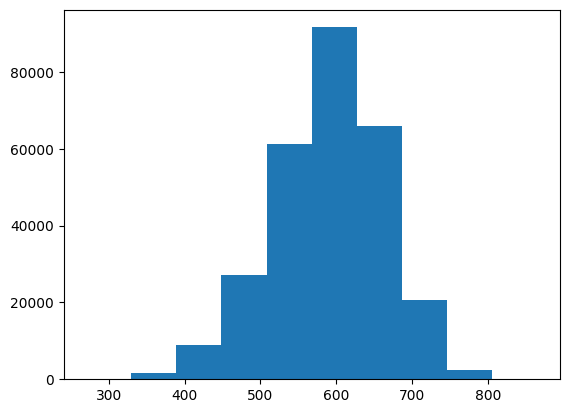

In [34]:
plt.hist(df_score["Score_ind"])